# CS5489 - Machine Learning
# Lecture 6b - Linear Dimensionality Reduction for Text
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Dimensionality Reduction for Vectors
2. **Linear Dimensionality Reduction for Text**
3. Non-linear Dimensionality Reduction
4. Manifold Embedding

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
- **Goal:** Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data represent co-occuring features in high-dim data.
  - Dimensions in the low-dim data may have semantic meaning.


- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<center><img src="imgs/topic.png" width=500px></center>

# Latent Semantic Analysis (LSA)
- Also called _Latent Semantic Indexing_
- Consider a bag-of-word representation (e.g., TF, TF-IDF)
  - document vector $\mathbf{x}_i$ 
  - $x_{i,j}$ is the frequency of word $j$ in document $i$

- Approximate each document vector as a weighted sum of topic vectors.
  - $\hat{\mathbf{x}} = \sum_{n=1}^p w_p \mathbf{v}_p$
  - Topic vector $\mathbf{v}_p$ contains co-occuring words.
    - corresponds to a particular _topic_ or _theme_.
  - Weight $w_p$ represents similarity of the document to the p-th topic.
- Objective: 
  - minimize the squared reconstruction error (Similar to PCA):
  - $\min_{\mathbf{v},\mathbf{w}} \sum_i ||\mathbf{x}_i - \hat{\mathbf{x}}_i||^2$
  - Solution computed using SVD.

- Represent each document by its topic weights.
  - Apply other machine learning algorithms...
- **Advantage:**   
  - Finds relations between terms (synonymy and polysemy).
  - distances/similarities are now comparing topics rather than words.
    - higher-level semantic representation

# Example on Spam Email dataset
- use bag-of-words representation with 50 words
- term-frequency (TF) normalization

In [2]:
# Load spam/ham text data from directories
textdata = datasets.load_files("email", encoding="utf8", decode_error="replace")

# convert to bag-of-words representation
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=50)
X = cntvect.fit_transform(textdata.data)
Y = textdata.target

# TF representation
tf_trans = feature_extraction.text.TfidfTransformer(norm='l1', use_idf=False)
Xtf = tf_trans.fit_transform(X)

# print the vocabulary
print(cntvect.vocabulary_)

{'online': 39, 'watches': 49, 'brands': 13, 'bags': 11, 'new': 35, 'today': 46, 'hi': 25, 'peter': 42, 'contact': 17, 'mr': 34, 'email': 21, 'com': 16, 'number': 37, 'country': 19, 'nigeria': 36, 'answer': 10, 'status': 44, 'good': 23, 'day': 20, 'john': 30, 'united': 47, 'payment': 40, 'bank': 12, 'address': 9, 'information': 28, 'inform': 27, '10': 2, 'office': 38, 'kamara': 32, '000': 1, 'codeine': 15, '30mg': 6, '30': 5, '00': 0, '60': 8, 'pills': 43, '120': 3, 'just': 31, 'cost': 18, 'buy': 14, 'mg': 33, 'percocet': 41, '50': 7, '15mg': 4, 'visa': 48, 'isidoro': 29, 'store': 45, 'http': 26, 'google': 24, 'files': 22}


# LSA on Spam data
- Apply LSA  with 5 topics
  - implemented as `TruncatedSVD`

In [3]:
lsa = decomposition.TruncatedSVD(n_components=5, random_state=4487)
Wlsa = lsa.fit_transform(Xtf) 

# components
V = lsa.components_ 

In [4]:
rbow = plt.get_cmap('rainbow')
def get_top_word_inds(T, vocab, mode='1std'):
    # return indices of the largest component entries    
    absT = abs(T)
    
    # get 5 largest values
    if (mode=='top5'):
        tmp = argsort(absT)[::-1]
        topinds = tmp[0:5]
            
    elif (mode=='accum'):
        # select by accumulating
        tmpx = argsort(absT)[::-1]
        mags = absT[tmpx]
        magsc = cumsum(mags)
        magsc /= magsc[-1]
        #print magsc    
        cumu = sum(magsc < 0.50)
        topinds = tmpx[0:cumu]
        
    elif ('1std'):
        # select words with magnitude of 1-std above mean
        mymn = mean(absT)
        mystd = std(absT)
        topinds = where(absT > mymn+mystd)[0]
        
    # get the words
    topwords = []
    for q in topinds:
        mystr = vocab[q]
        if T[q]<0:
            mystr = "!" + mystr            
        topwords.append(mystr)
            
    return topinds, topwords

def get_model(model):
    if model.__class__.__name__ == 'LatentDirichletAllocation':
        K = model.components_.shape[0]
        comps = model.components_.copy()
        # normalize to a probability distribution
        comps /= sum(comps,axis=1)[:,newaxis]
    else:
        K = model.n_components
        comps = model.components_
    return (K, comps)

def plot_topics(model, vocab, ind=None, figsize=(8,6), sp=None):
    # ind= topic indices to plot
    # figsize= figure size
    # sp= subplot indices (use None for default): [sy, sx, inds]
    K, comps = get_model(model)

    Xr = arange(model.components_.shape[1])
    lsafig = plt.figure(figsize=figsize)
    
    if ind is None:
        ind = range(K)
    if sp is None:
        sy = len(ind)
        sx = 1
        spinds = range(1,sy+1)
    else:
        sy = sp[0]
        sx = sp[1]
        spinds = sp[2:]
    
    for ip,j in enumerate(ind):
        plt.subplot(sy,sx,spinds[ip])
        # get components
        T = comps[j,:]

        tmp,topwords = get_top_word_inds(T, vocab)
    
        plt.bar(Xr, T, color='none', edgecolor='k')
        plt.plot(tmp, T[tmp], 'bo')
        # plot words on the top 5
        TW = []
        for i,q in enumerate(tmp):
            mystr = topwords[i]
#            plt.annotate(xy=(q+0.4,T[q]), text=mystr, 
#                         xytext=(q+0.4,T[q]),  rotation=45, 
#                         ha='left', va='bottom', color='r')
            plt.annotate(xy=(q+0.4,T[q]-0.05), text=mystr, 
                         xytext=(q+0.4,T[q]-0.05), 
                         ha='left', va='bottom', color='r')
        plt.grid(True)
        plt.ylabel('Topic ' + str(j+1))
        if ip == sy-1:
            plt.xlabel('words')
        else:
            plt.gca().set_xticklabels([])
        plt.xlim(Xr[0]-0.5, Xr[-1]+.5)
    if sp is None:
       # plt.tight_layout()
        plt.close()
    return lsafig

# Topic vectors
- topic vectors contain frequent co-occuring words

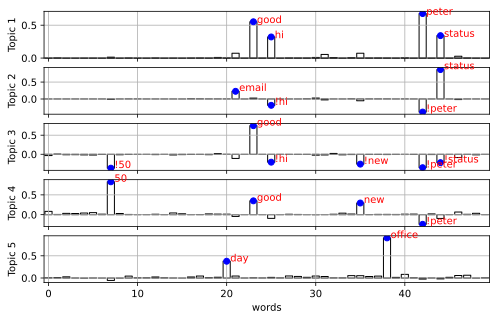

In [5]:
vocab = asarray(cntvect.get_feature_names())
lsafig = plot_topics(lsa, vocab, figsize=(8,5))
lsafig

# Document representation
- Documents are a combination of topics

In [6]:
def plot_doc_topic(myXtf, myW, model, vocab):    
    docfig = plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    K, comps = get_model(model)
    Xr = arange(comps.shape[1])
    myXtfa = myXtf.toarray().flatten()
    plt.bar(Xr, myXtfa, lw=1, color="none", label='document', edgecolor='k')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    for j in range(K):
        T = comps[j,:]
        mystr = "Topic " + str(j+1) + " ($w_"+str(j+1)+"$=% .4f"%(myW[j],) + ") "
               
        # get largest values, and add words
        tmp, topwords = get_top_word_inds(T, vocab)
        mystr += " ".join(topwords)
        plt.bar(Xr, myW[j]*T, color="none", edgecolor=rbow(float(j)/K), lw=2, label=mystr)
        
    plt.grid(True); plt.xlabel('words')
    tmpax = plt.axis()
    plt.axis([Xr[0]-0.5, Xr[-1]+0.5, tmpax[2], 1.0])
    plt.legend(fontsize=8, loc='upper center')

    plt.subplot(2,1,2)
    plt.bar(Xr, myXtfa, lw=1, color="none", label='original document', edgecolor='k')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    newX = dot(myW[newaxis,:],comps).flatten()
    plt.bar(Xr, newX, color="none", edgecolor='r', lw=2, label='reconstruction')
    
    # get largest values
    cols = ('k', 'r')
    for i,T in enumerate([myXtfa, newX]):
        if i==0:
            tmp = where(abs(T)>=0.1)[0]
        else:
            tmp = where((abs(T)>=0.1) & (abs(myXtfa)<0.1))[0]
        #plt.plot(tmp+0.4, T[tmp], 'ko')
        for q in tmp:
            mystr = vocab[q]
            if T[q]<0:
                mystr = "!" + mystr
            plt.annotate(xy=(q+0.4,T[q]), text=mystr, 
                         xytext=(q+0.4,T[q]), rotation=45, 
                         ha='left', va='bottom', color=cols[i])
            
    plt.grid(True)
    plt.xlabel('words')
    plt.axis([Xr[0]-0.5, Xr[-1]+0.5, tmpax[2], 1.0])
    plt.legend(fontsize=8, loc='upper center')
    plt.close()
    return docfig

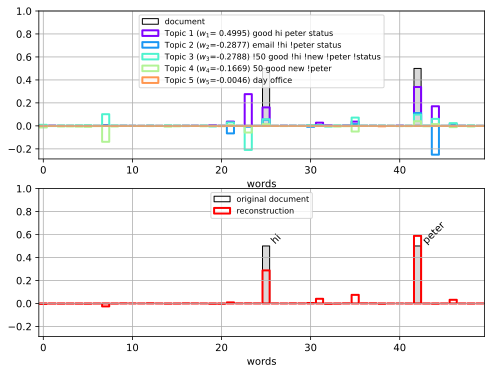

In [7]:
plot_doc_topic(Xtf[2,:], Wlsa[2,:], lsa, vocab)

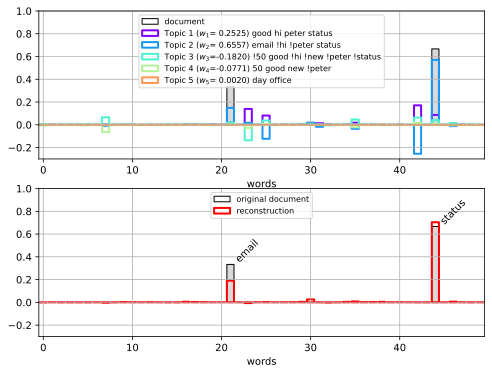

In [8]:
plot_doc_topic(Xtf[4,:], Wlsa[4,:], lsa, vocab)

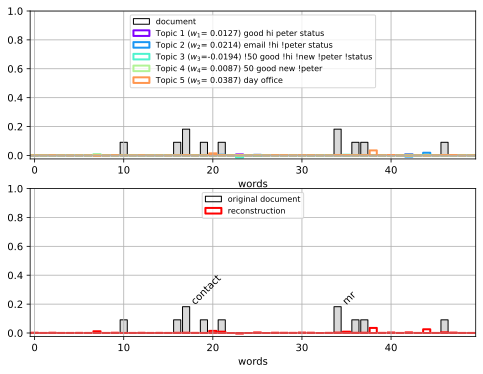

In [9]:
plot_doc_topic(Xtf[3,:], Wlsa[3,:], lsa, vocab)

# Problem with LSA
- In the topic vector, the "frequency" of a word can be negative!
  - Doesn't really make sense for document bag-of-words model.

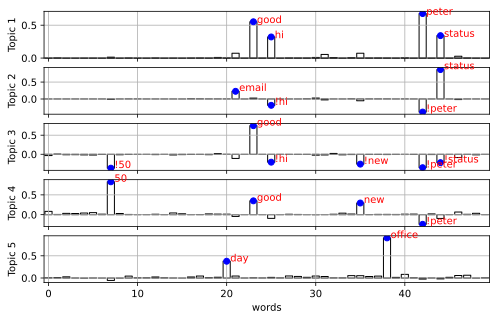

In [10]:
lsafig

# Problems with LSA
- The weights for each topic can be negative!
  - Topics should only be "additive"
    - Topics should increase probability of some topic-related words, but not decrease probability of other words.
    - It doesn't make sense to "remove" a topic using a negative topic weight.

In [11]:
pfig = plt.figure(figsize=(8,2))
for i,e in enumerate([2, 4, 7, 16]):
    plt.subplot(1,4,i+1)
    plt.bar(range(5), Wlsa[e,:], edgecolor='k')
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([-0.5 ,4.5,-0.3,1])
plt.tight_layout()
plt.close()

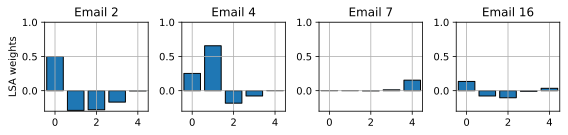

In [12]:
pfig

# Non-negative Matrix Factorization (NMF)
- **Solution:** constrain the topic vector and weights to be non-negative.
- Similar to LSA
  - Approximate each document vector as a weighted sum of topic vectors.
    - $\hat{\mathbf{x}}_j = \sum_{n=1}^p w_p \mathbf{v}_p$
    - But now, each entry of topic vector $\mathbf{v}_p\geq 0$ and topic weight $w_p\geq 0$
  - Objective: minimize the squared reconstruction error
     $$\min_{\mathbf{v}\geq 0,\mathbf{w}\geq0} \sum_j ||\mathbf{x}_j - \hat{\mathbf{x}}_j||^2$$
    - subject to the non-negative constraints.
    - no closed-form solution, need to use an optimizer.

In [13]:
# Run NMF
nmf = decomposition.NMF(n_components=5)
Wnmf = nmf.fit_transform(Xtf) 

# components
V = nmf.components_ 

# Topic vector
- all non-negative entries
- looks much cleaner (less small entries)

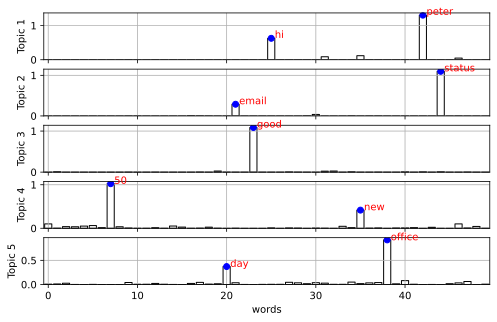

In [14]:
plot_topics(nmf, vocab, figsize=(8,5))

# Document vector
- additive combination of topics

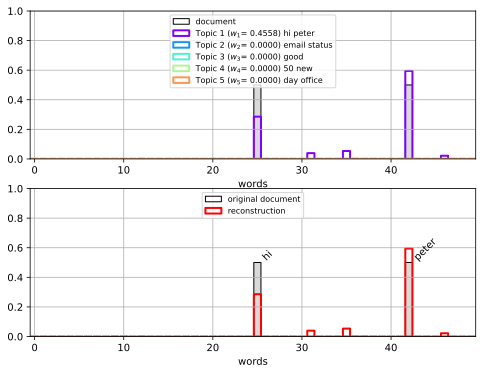

In [15]:
plot_doc_topic(Xtf[2,:], Wnmf[2,:], nmf, vocab)

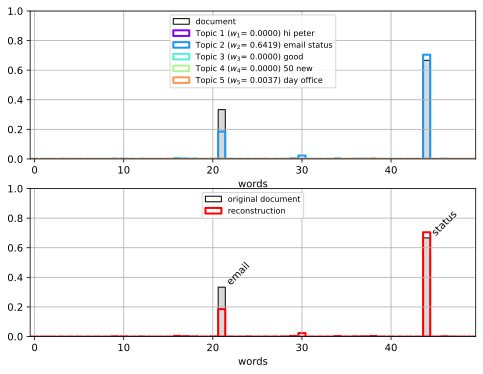

In [16]:
plot_doc_topic(Xtf[4,:], Wnmf[4,:], nmf, vocab)

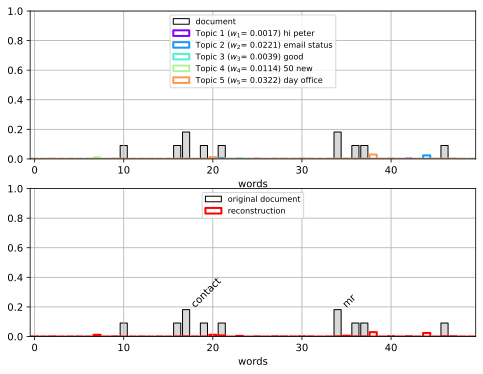

In [17]:
plot_doc_topic(Xtf[3,:], Wnmf[3,:], nmf, vocab)

# Sparseness
- For NMF representation, most topic weights for a document are zero.
  - this is called a _sparse_ representation.
  - each document is only composed of a few topics.

In [18]:
spfig = plt.figure(figsize=(8,4))
for i,e in enumerate([2, 4, 7, 16]):
    plt.subplot(2,4,i+1)
    plt.bar(range(5), Wlsa[e,:])
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([-0.5,4.5,-0.3,1])
    plt.subplot(2,4,i+1+4)
    plt.bar(range(5), Wnmf[e,:])
    plt.axis([-.5,4.5,-0.3,1])
    if i==0:
        plt.ylabel('NMF weights')
    plt.grid(True)
plt.tight_layout()
plt.close()

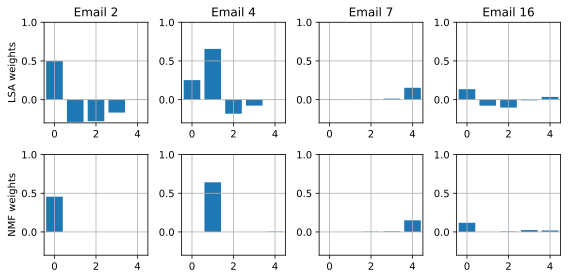

In [19]:
spfig

# Problem with NMF
- _While the weights and component vectors are non-negative, NMF does not enforce them to be  probabilities._

In [20]:
nfig = plot_topics(nmf, vocab, [0], figsize=(8,2), sp=(1,2,1))
plt.subplot(1,2,2)
plt.bar(range(5), Wnmf[1,:], edgecolor='k');
plt.xlabel('topic number'); plt.ylabel('NMF weight')
plt.grid(True)
plt.tight_layout()
plt.close()

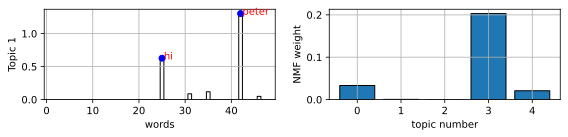

In [21]:
nfig

- TF/TFIDF is a probabilistic model of words in a document
  - the vector of probabilities sums to 1
  - probabilities are between 0 and 1
- The NMF components and weights are difficult to interpret.
- *We will solve this problem later using probabilistic graphical models.*

# Linear Dimensionality Reduction - Summary
- **Goal:** given set of input vectors $\{\mathbf{x}_i\}_{i=1}^n$, with $\mathbf{x}_i\in\mathbb{R}^d$, represent each input vector as lower-dimensional vector $\mathbf{w}_i \in \mathbb{R}^p$.
  - Approximate $\mathbf{x}$ as a weighted sum of basis vectors $\mathbf{v}_j\in \mathbb{R}^d$
    - $\hat{x} = \sum_{j=1}^p w_j \mathbf{v}_j$
    - minimize the reconstruction error of $\hat{\mathbf{x}}$.
  - enables faster processing, or reduces noise.
  
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Objective</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Principal component analysis (PCA)</td>
<td>minimize reconstruction error; preserve the most variance of data</td>
<td>- captures correlated dimensions, removes redundant dimensions, removes noise.<br>- closed-form solution</td>
<td>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Random Projections</td>
<td>sample random basis vectors.</td>
<td>- fast.<br>- preserves pairwise distances between points (up to accuracy factor).</td>
<td>- adds noise to the pairwise distances.</td>
</tr>
<tr>
<td>Fisher's Linear Discriminant (FLD)</td>
<td>maximize class separation</td>
<td>- preserves class separation</td>
<td>- requires class information</td>
</tr>
<tr>
<td>Latent Semantic Analysis (LSA)</td>
<td>minimize reconstruction error</td>
<td>- topic vectors have semantic meaning (co-occuring words)<br>- closed-form solution</td>
<td>- topic weights and topic vectors can be negative<br>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Non-negative Matrix Factorization (NMF)</td>
<td>minimize reconstruction error; non-negative weights and basis vectors.</td>
<td>- "additive" topic/parts model for text or images<br>- sparse topic weights.</td>
<td>- solution requires iterative algorithm.<br>- does not consider end goal (e.g., classification)</td>
</tr>
</table>

# Other things
- _Feature Normalization_
  - PCA and LDA are based on the covariance between input dimensions.
  - applying _per-feature_ normalization will yield a different PCA result!
    - normalizing each input dimension changes the relative covariances.

In [23]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None, axbox1=None, axbox2=None):
    if sp is None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    axh = [None, None]
    
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp is None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    axh[0] = plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    plt.scatter(X[:,0], X[:,1], s=5, edgecolor="none", c=Y, cmap=mycmap, edgecolors='k')
    if axbox1 is not None:
        plt.axis(axbox1)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Original space (x)')
    
    tmp = plt.xlim()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    Ls = []
    LL = []
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], width=lw, head_width=hw, 
                        color=cols[j], length_includes_head=True)
        Ls.append(tmp)
        LL.append("PC "+str(j))

    plt.plot(Xm[0], Xm[1], 'ks')
    if showleg:
        plt.legend(Ls, LL, loc='lower right')
        
    axh[1] = plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=10, marker='x', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w')

    if axbox2 is not None:
        plt.axis(axbox2)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Low-dim space (w)')
    
    return axh

In [24]:
iris = datasets.load_iris()
X = iris.data[:,(2,1)]
Y = iris.target

# normalize the data
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)

# PCA on original
pca  = decomposition.PCA(n_components=1)
Wpca = pca.fit_transform(X)

# PCA on normalized
pca2  = decomposition.PCA(n_components=1)
Wpca2 = pca2.fit_transform(Xs)

nfig = plt.figure(figsize=(8,4))
axh1 = plot_basis(X, pca.components_, sp=((2,2,1),(2,2,2)), Y=Y)
axh2 = plot_basis(Xs, pca2.components_, sp=((2,2,3),(2,2,4)), Y=Y)
plt.sca(axh2[0])
plt.title('Normalized space (x)')
plt.tight_layout()
plt.close()

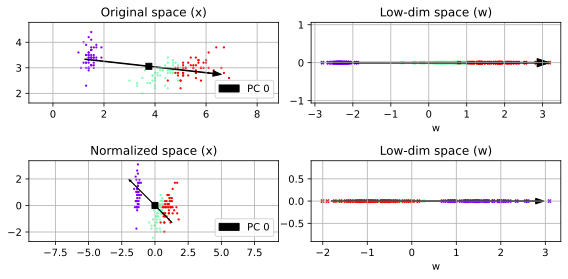

In [25]:
nfig